In [16]:
import sys
import pandas as pd
sys.path.append("..")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploratory Data Analysis


## ROI per Cohort - Mathematical Formulation

We define a **cohort** $c$, created at time $t=0$. For each loan $i \in c$:

- $L_i $: principal loan amount granted.  
- $R_i(t) $: cumulative repayments (including normal repayments and collections) up to time $t$.  
- $L_i$ : amount of loan $i$.

The **net cash flow** $F_i$ of loan $i$ up to time $t$ is:

$$
F_i(t) = R_i(t) - L_i
$$

The **net cash flow of cohort $c$** up to time $t$ is:

$$
F_c(t) = \sum_{i \in c} F_i(t) = \sum_{i \in c} \big(R_i(t) - L_i\big)
$$

The **Return on Investment (ROI)** for cohort $c$ up to time $t$ is defined as:

$$
ROI_c(t) = \frac{F_c(t)}{\sum_{i \in c} L_i}
$$

or equivalently:

$$
ROI_c(t) = \frac{\sum_{i \in c} R_i(t)}{\sum_{i \in c} L_i} - 1
$$

### Properties

- At the start ($t=0$), repayments are zero, so $ROI_c(0) = -1$.  
- As repayments occur, $ROI_c(t)$ increases.  
- If $ROI_c(t) > 0$, the cohort has become profitable at horizon $t$.  

## Computing ROI curves

The initial step involves creating a consolidated table that combines repayment data, loan details, and batch identifiers. This comprehensive table will enable us to group repayments by batch and subsequently calculate the Return on Investment (ROI) curves for each cohort.

In [21]:
from src.data_loading import load_data

# Load and prepare all data
allowlist, loans, repayments, loans_and_cohort, repayments_and_loans = load_data("../database.db")

In [12]:
# Dataframe of loans with cohort information
display(loans_and_cohort.head())

,date,loan_id,repayment_amount,billings_amount,user_id,created_at,updated_at,annual_interest,loan_amount,status,batch,allowlisted_date
0,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2022-12-27 18:06:03.902000+00:00,2.4,9750.0,debt_collection,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29
1,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2022-12-13 01:00:01.294000+00:00,2.4,9750.0,debt_collection,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29
2,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2025-01-07 22:30:20.346000+00:00,2.4,9750.0,debt_collection,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29
3,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2022-08-30 17:44:27.679729+00:00,2.4,9750.0,executed,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29
4,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2022-10-10 12:42:46.269064+00:00,2.4,9750.0,executed,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29


In [22]:
# Dataframe of repayments with loans and cohort information
display(repayments_and_loans.head())

,date,loan_id,repayment_amount,billings_amount,user_id,created_at,updated_at,annual_interest,loan_amount,status,batch,allowlisted_date
0,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2022-12-27 18:06:03.902000+00:00,2.4,9750.0,debt_collection,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29
1,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2022-12-13 01:00:01.294000+00:00,2.4,9750.0,debt_collection,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29
2,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2025-01-07 22:30:20.346000+00:00,2.4,9750.0,debt_collection,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29
3,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2022-08-30 17:44:27.679729+00:00,2.4,9750.0,executed,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29
4,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2022-10-10 12:42:46.269064+00:00,2.4,9750.0,executed,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29


Now, let's create three important columns:
- **cohort_start:** the date when the user was allowlisted
- **h_days:** the number of days since the cohort_start until the repayment date
- **repayment_total:** the total amount repaid by the user, including both normal repayments and collections.

In [23]:
from src.data_loading import prepare_roi_columns

# Prepare additional columns for ROI calculations
repayments_and_loans = prepare_roi_columns(repayments_and_loans)

display(repayments_and_loans.head())

,date,loan_id,repayment_amount,billings_amount,user_id,created_at,updated_at,annual_interest,loan_amount,status,batch,allowlisted_date,cohort_start,h_days,repayment_total
0,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2022-12-27 18:06:03.902000+00:00,2.4,9750.0,debt_collection,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29,2022-08-29,106,0.15
1,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2022-12-13 01:00:01.294000+00:00,2.4,9750.0,debt_collection,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29,2022-08-29,106,0.15
2,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2025-01-07 22:30:20.346000+00:00,2.4,9750.0,debt_collection,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29,2022-08-29,106,0.15
3,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2022-08-30 17:44:27.679729+00:00,2.4,9750.0,executed,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29,2022-08-29,106,0.15
4,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,7ab6fd45808f75f1288602bc268917bd67cbe9a136f833...,2022-08-30,2022-10-10 12:42:46.269064+00:00,2.4,9750.0,executed,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29,2022-08-29,106,0.15


Now, we need to compute the loan amount per batch.

In [24]:
cohort_principal = loans_and_cohort.groupby("batch")["loan_amount"].sum().rename("cohort_principal")
display(cohort_principal)

batch
1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e2157841bfff5fa732465    2.691901e+06
1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f3741fe1eac98731f61    8.433909e+07
22bda9c4992b30b6b347e22c27f9e59fb9ce99f1072389373820e5ed747bdd71    1.146123e+08
4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640b4e0e049e7a95e8e7f    9.982618e+06
5bcbc3d39978a3ff54a2671faf77e3e43c798faf53e98f6d27810f35a57346a1    5.177875e+07
9a65c2254d6d2b240f353b95df7061928c7a9869417325770f461463271a3b65    3.014135e+07
e6a25e071c60243b0c51c698db5302b54ef61338c6747a79598215f4d982028b    1.214050e+07
Name: cohort_principal, dtype: float64

Now, let's group the loans by batch and days since cohort start, summing the repayments. Then, we will compute the cumulative sum of repayments over time for each batch.

In [38]:
repayment_curve = (
    repayments_and_loans.groupby(
        ["batch", "h_days"]
    )["repayment_total"]
    .sum()
    .groupby(level=0)
    .cumsum()
    .reset_index()
)

Finally, we will merge the cumulative repayments with the principal amounts to calculate the ROI for each cohort over time.

In [39]:

repayment_curve = repayment_curve.merge(cohort_principal, on="batch")
repayment_curve["ROI"] = repayment_curve["repayment_total"] / repayment_curve["cohort_principal"] - 1

display(repayment_curve.head(10))

,batch,h_days,repayment_total,cohort_principal,ROI
0,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,0,602.640000,2691900.82,-0.999776
1,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,1,2676.610000,2691900.82,-0.999006
2,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,2,10170.010000,2691900.82,-0.996222
3,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,3,11044.880000,2691900.82,-0.995897
4,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,4,21928.609108,2691900.82,-0.991854
5,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,5,31932.031864,2691900.82,-0.988138
6,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,6,37897.900812,2691900.82,-0.985922
7,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,7,40596.892908,2691900.82,-0.984919
8,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,8,49112.188080,2691900.82,-0.981756
9,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,9,56291.723860,2691900.82,-0.979088


Now, we can iterate over each batch to plot the ROI curves.

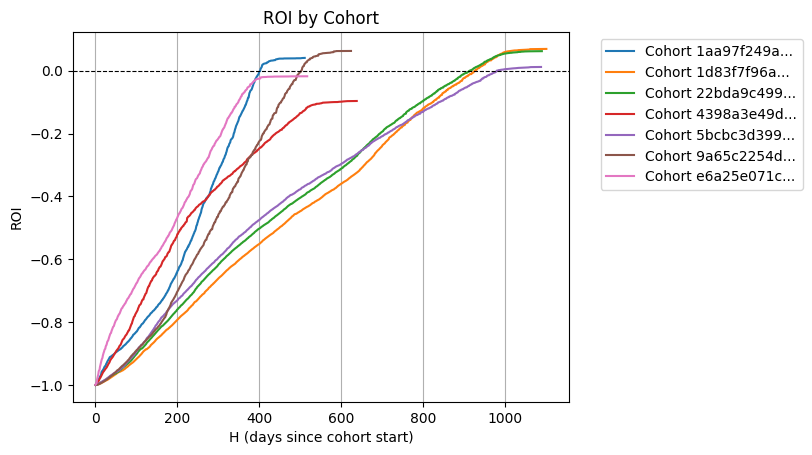

In [54]:
import matplotlib.pyplot as plt

for batch, g in repayment_curve.groupby("batch"):

    plt.plot(g["h_days"], g["ROI"], label=f"Cohort {batch[:10]}...")

plt.title("ROI by Cohort")
plt.xlabel("H (days since cohort start)")
plt.ylabel("ROI")
plt.grid(which='both', axis='x')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Questions to answer, facts, and notes

**Facts**
- 1 - the repayment is not acumulative.
- 2 - alguns usuários não possuem empréstimos ativos, alguns batchs inteiros não possuem empréstimos.

**Questions**
- 1 - todos os emprestimos de um cohort começam a partir do inicio dele?